In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import compress

from datetime import datetime
from dateutil.parser import parse

import math
import os
import copy
import pickle

import drugLookup

## Import Data

In [2]:
# Read in data (from pickle file)
file = open('drug_df','rb')
drug_df = pickle.load(file)

In [3]:
drug_df.head()

,transaction_id,vendor_id,vendor_name,bitcoin_amt,USD,product_description,date,drug_prediction
9430,'10528,590,superclr,-1.0,416.000,5 GRAMS GRADE AAA+ CARTEL TAN POWDER HEROIN,2018-11-02 06:43:01,heroin
9431,'10529,590,superclr,-1.0,416.000,5 GRAMS GRADE AAA+ CARTEL TAN POWDER HEROIN,2018-11-10 06:43:01,heroin
9434,'10532,92,OnionKings,-1.0,109.119,Rivotril 2mg från apotek (Roche) [100st],1969-12-31 19:00:00,benzodiazepines
9435,'10533,92,OnionKings,-1.0,109.119,Rivotril 2mg från apotek (Roche) [100st],2018-12-21 06:43:11,benzodiazepines
9436,'10534,92,OnionKings,-1.0,109.119,Rivotril 2mg från apotek (Roche) [100st],1969-12-31 19:00:00,benzodiazepines


## Compute revenue for each vendor

In [4]:
vendor_list = pd.unique(drug_df['vendor_name'])

In [5]:
# Function to compute the revenue of a single vendor
def getVendorRevenue(vendor):
    vendor_subset = drug_df[drug_df['vendor_name'] == vendor]
    return(np.sum(vendor_subset['USD']))

In [6]:
# Get revenue for each vendor
vendor_revenues = {vendor : getVendorRevenue(vendor) for vendor in vendor_list}

In [9]:
# add revenues to dataframe
vendor_revenue_df = pd.DataFrame.from_dict(vendor_revenues, orient = 'index', columns = {'revenue'})
sorted_revenue_by_vendor = vendor_revenue_df.sort_values(by = 'revenue', ascending = False)['revenue']
at_least_100000_sales = np.where(sorted_revenue_by_vendor < 50000)[0][0]
at_least_10000_sales = np.where(sorted_revenue_by_vendor < 10000)[0][0]
at_least_1000_sales = np.where(sorted_revenue_by_vendor < 1000)[0][0]
at_least_100_sales = np.where(sorted_revenue_by_vendor < 100)[0][0]

# Get cumulative sum of series
cumulative_sales = [np.sum(sorted_revenue_by_vendor[:i+1]) for i in range(len(sorted_revenue_by_vendor))]
total_revenue = cumulative_sales[-1]

In [10]:
# Find number of vendors who account for 50% of sales
def getVendorProp(percent):
#     Function to get the proportion of vendors who represent given percent of total revenue
#     Args: percent of revenue; percent should be in range [0,100]
#     Returns: percent of vendors accounting for this percent of revenue, also in range [0,100]
    cutoff_idx = np.nonzero(cumulative_sales >= (total_revenue*(percent/100)))[0][0]
    return(100*cutoff_idx / len(cumulative_sales), cutoff_idx)

print('Percentage of vendors accounting for given % of revenue:')
print('50%:', getVendorProp(50)[0])
print('75%:', getVendorProp(75)[0])
print('90%:', getVendorProp(90)[0])
print('99%:', getVendorProp(99)[0])

# Find revenue which top n% of vendors account for
def getRevenueProp(vendor_percent):
#     Function to get the proportion of revenue which given percent of vendors account for
#     Args: percent of vendors; percent should be in range [0,100]
#     Returns: percent of revenue which given percentage of vendors account for, also in range [0,100]
    # get number of vendors to include
    n_vendors = int(np.round(len(cumulative_sales) * (vendor_percent/100)) )
    # Divide revenue for top n vendors by total revenue
    return(100 * cumulative_sales[n_vendors]/cumulative_sales[-1], n_vendors) 

print('\n\nPercentage of revenue accounted for by given % of vendors:')
print('1% :', getRevenueProp(1)[0])
print('5% :', getRevenueProp(5)[0])
print('10%:', getRevenueProp(10)[0])
print('30%:', getRevenueProp(30)[0])

Percentage of vendors accounting for given % of revenue:
50%: 5.613178767541184
75%: 15.924344112263576
90%: 31.84868822452715
99%: 67.41915802318486


Percentage of revenue accounted for by given % of vendors:
1% : 21.306755860259138
5% : 47.667447384431945
10%: 63.56187235371336
30%: 88.87738924979259


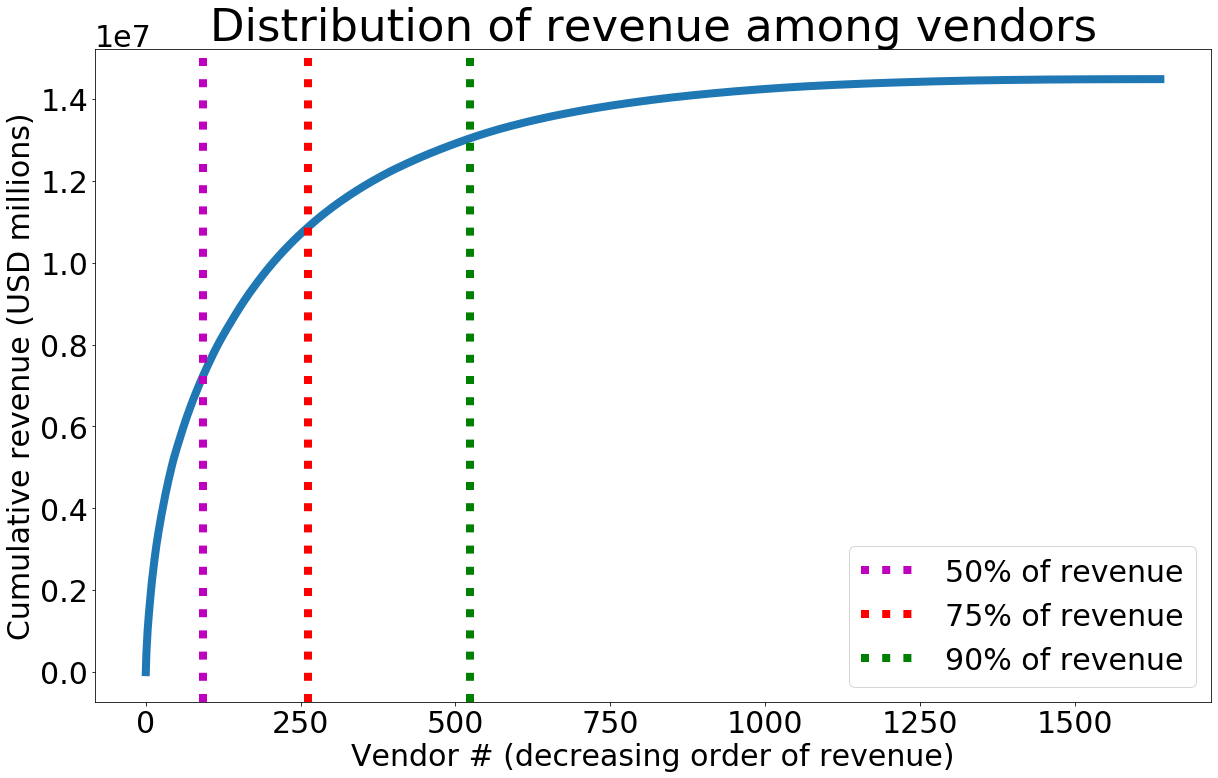

In [116]:
# Plot results
fs = 30
lw = 8
plt.rcParams.update({'font.size': 30})
t = plt.figure(figsize=(20,12))
plt.plot(cumulative_sales, linewidth = lw)
plt.axvline(x=getVendorProp(50)[1], color = 'm',linestyle = ':', label = '50% of revenue', linewidth = lw)
plt.axvline(x=getVendorProp(75)[1], color = 'r',linestyle = ':', label = '75% of revenue', linewidth = lw)
plt.axvline(x=getVendorProp(90)[1], color = 'g',linestyle = ':', label = '90% of revenue', linewidth = lw)
# plt.axvline(x=getVendorProp(99)[1], color = 'k',linestyle = ':', label = '99% of revenue', linewidth = lw)
plt.xlabel('Vendor # (decreasing order of revenue)', fontsize = fs)
plt.ylabel('Cumulative revenue (USD millions)', fontsize = fs)
plt.title('Distribution of revenue among vendors', fontsize = fs*1.5)
plt.legend(fontsize = fs, loc = 'best')

plt.show()
t.savefig('revenue_plot.png', dpi = 500)

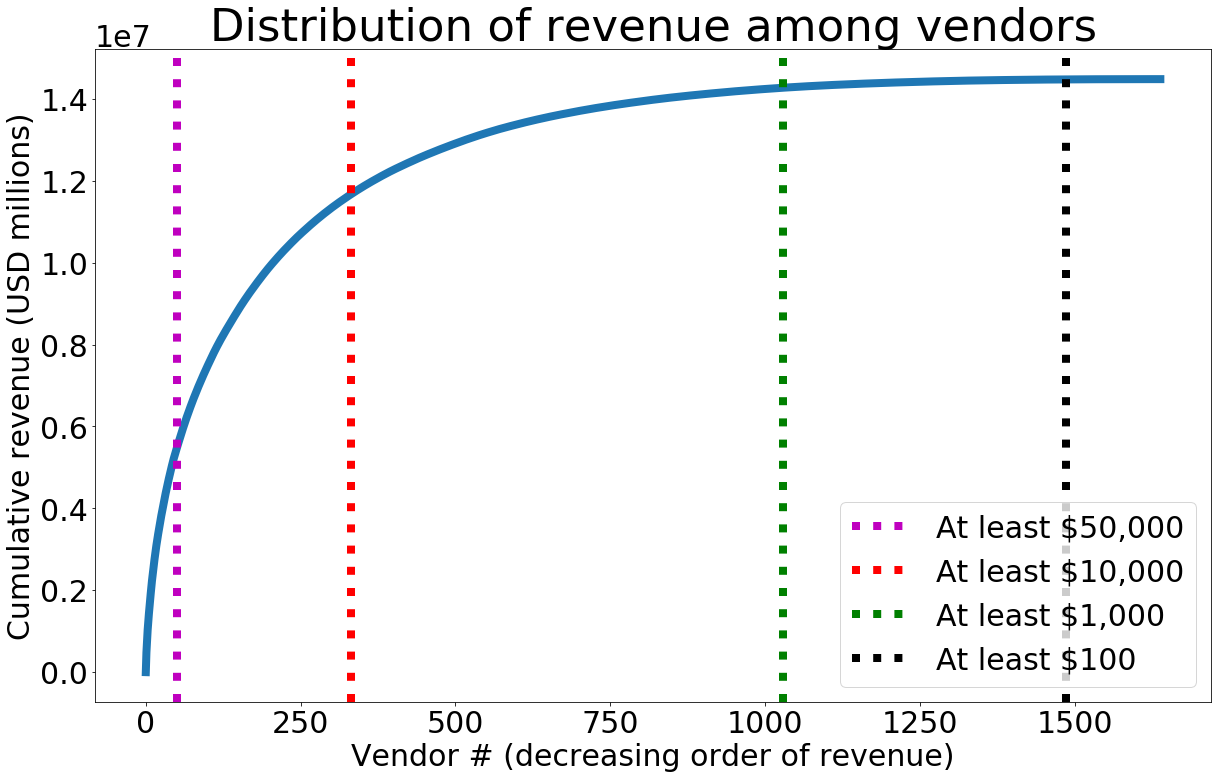

In [109]:
# Plot results
fs = 30
lw = 8
plt.rcParams.update({'font.size': 30})
t = plt.figure(figsize=(20,12))
plt.plot(cumulative_sales, linewidth = lw)
plt.axvline(x=at_least_100000_sales, color = 'm',linestyle = ':', label = 'At least $50,000', linewidth = lw)
plt.axvline(x=at_least_10000_sales, color = 'r',linestyle = ':', label = 'At least $10,000', linewidth = lw)
plt.axvline(x=at_least_1000_sales, color = 'g',linestyle = ':', label = 'At least $1,000', linewidth = lw)
plt.axvline(x=at_least_100_sales, color = 'k',linestyle = ':', label = 'At least $100', linewidth = lw)
plt.xlabel('Vendor # (decreasing order of revenue)', fontsize = fs)
plt.ylabel('Cumulative revenue (USD millions)', fontsize = fs)
plt.title('Distribution of revenue among vendors', fontsize = fs*1.5)
plt.legend(fontsize = fs, loc = 'best')

plt.show()
t.savefig('revenue_plot.png', dpi = 500)

## Compute Gini index

Formula for Gini index:
$G(x) = \frac{\sum^n_{i=1}(2i-n-1)x_i}{n^2\mu}$

In [71]:
# Function to get Gini index
def getGini(x):
#     Function to compute the Gini index of a sequence ordered in increasing order (technically non-decreasing order)
    numerator_sum = 0 # initialize numerator
    n = len(x) # number of elements in sequence
    mu = np.mean(x) # mean of sequence
    mu += .00000000001 # ensure not dividing by zero
    
    # Compute sum of numerator
    for i, x_i in enumerate(x):
        numerator_sum += (2*(i+1) - n - 1) * x_i
        
    # Divide numerator by denominator
    G = numerator_sum / (n**2 * mu)
    return(G)

In [96]:
# Construct Lorenz curve
sorted_revenue_ascending = vendor_revenue_df.sort_values(by = 'revenue', ascending = True)['revenue']
cum_sales_ascending = [np.sum(sorted_revenue_ascending[:i+1]) for i in range(len(sorted_revenue_ascending))]

# Normalize values to between 0 and 1 for Gini calculation
cum_sales_ascending_normal = cum_sales_ascending / cum_sales_ascending[-1]

# Get normalized x_vals for plotting
x_vals = np.array([i for i in range(1, len(cum_sales_ascending)+1)])
x_vals = x_vals/x_vals[-1]

In [107]:
# Compute the Gini index
revenue_gini = getGini(cum_sales_ascending)
print('Gini index:',revenue_gini)

Gini index: 0.6939925670399744


In [105]:
def gini(ar):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    ar = ar.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(ar) < 0:
        array -= np.amin(ar) #values cannot be negative
    ar = ar + 0.0000001 #values cannot be 0
    ar = np.sort(ar) #values must be sorted
    index = np.arange(1,ar.shape[0]+1) #index per array element
    n = ar.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * ar)) / (n * np.sum(ar))) #Gini coefficient

In [106]:
gini(np.array(cum_sales_ascending))

0.6939925670399334

In [140]:
a = [1,2,3]
print(range(len(a)))
# np.sum(a[:6])
for i in range(len(a)):
    print(np.sum(a[0:i+1]))

range(0, 3)
1
3
6


In [108]:
print('hello_world')

hello_world
